In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import scipy, sqlite3, h5py

import pandas as pd

import sklearn
import sklearn.model_selection as model_selection
from sklearn.preprocessing import StandardScaler

import rampy as rp
import neuravi
import sys

In [2]:
def pretreatment(dataset,split_valid,split_test,output_file, rand_state=81):

    print('Reading data...')
    # reading the Pandas dataframe
    dataset = neuravi.chimie_control(dataset)
    #ap, b = vp.heatcp(dataset,Cp_glass = "3R") # Cp coeffs
    #n_b_o = vp.nbot(dataset) # NBO/T
    #ionicfs = vp.ifs(dataset) # IFS of metals

    #dataset['ap'] = ap
    #dataset['b'] = b
    #dataset['nbot'] = n_b_o['nbot']
    #dataset['ifsm'] = ionicfs['ifsm']
    #dataset['ifst'] = ionicfs['ifst']#.fillna(0.0)

    # train-valid-test split
    print("Splitting datasets...\n")
    tv_sub, test_sub, idxtv_sub, idxtest_sub = rp.chemical_splitting(dataset,'Name',split_fraction=split_test, rand_state=rand_state)
    train_sub, valid_sub, idxtrain_sub, idxvalid_sub = rp.chemical_splitting(tv_sub,'Name',split_fraction=split_valid, rand_state=rand_state)

    # For entropy dataset
    train_entropy = train_sub.dropna(subset=['Sc'])
    valid_entropy = valid_sub.dropna(subset=['Sc'])
    test_entropy = test_sub.dropna(subset=['Sc'])

    # For viscous Tg dataset, we drop the values at 0 (Tg not determined)
    train_tg = train_sub[train_sub.tg != 0]
    valid_tg = valid_sub[valid_sub.tg != 0]
    test_tg = test_sub[test_sub.tg != 0]
    
    # Now we need to fillna in other datasets
    train_sub = train_sub.fillna(0.0)
    valid_sub = valid_sub.fillna(0.0)
    test_sub = test_sub.fillna(0.0)

    #
    # viscosity dataset
    #
    
    X_columns = ["sio2","al2o3","na2o","k2o","T"]
    X_train = train_sub.loc[:,X_columns].values
    X_valid = valid_sub.loc[:,X_columns].values
    X_test = test_sub.loc[:,X_columns].values
    
    y_train = train_sub["viscosity"].values.reshape(-1,1)
    y_valid = valid_sub["viscosity"].values.reshape(-1,1)
    y_tv = tv_sub["viscosity"].values.reshape(-1,1)
    y_test = test_sub["viscosity"].values.reshape(-1,1)

    #
    # entropy dataset
    #
    X_columns = ["sio2","al2o3","na2o","k2o"]
    X_entropy_train = train_entropy.loc[:,X_columns].values
    X_entropy_valid = valid_entropy.loc[:,X_columns].values
    X_entropy_test = test_entropy.loc[:,X_columns].values
    
    y_entropy_train = train_entropy.loc[:,"Sc"].values
    y_entropy_valid = valid_entropy.loc[:,"Sc"].values
    y_entropy_test = test_entropy.loc[:,"Sc"].values
    
    #
    # tg split
    #
    X_tg_train = train_tg.loc[:,["sio2","al2o3","na2o","k2o"]].values
    X_tg_valid = valid_tg.loc[:,["sio2","al2o3","na2o","k2o"]].values
    X_tg_test = test_tg.loc[:,["sio2","al2o3","na2o","k2o"]].values
    
    y_tg_train = train_tg.loc[:,"tg"].values
    y_tg_valid = valid_tg.loc[:,"tg"].values
    y_tg_test = test_tg.loc[:,"tg"].values

    print("X training and validation set shape, unscaled")
    print(X_train.shape)
    
    print("X valid set shape, unscaled")
    print(X_valid.shape)
    
    print("X test set shape, unscaled")
    print(X_test.shape)
    
    print("\nEntropy training shape, unscaled")
    print(X_entropy_train.shape)

    print("Entropy validation shape, unscaled")
    print(X_entropy_valid.shape)

    print("Entropy testing shape, unscaled")
    print(X_entropy_test.shape)

    #
    # SCALING IS DEACTIVATED IN LAST VERSIONS (NO DIFFERENCE)
    #
    
    #print("... Scaling ...")
    # scaling
    #X_scaler = StandardScaler().fit(X_train)
    #Y_scaler = StandardScaler().fit(y_train)

    #X_entropy_train_sc = X_scaler.transform(X_entropy_train)
    #X_entropy_valid_sc = X_scaler.transform(X_entropy_valid)
    #X_entropy_test_sc = X_scaler.transform(X_entropy_test)

#     X_tv_sc = X_scaler.transform(X_tv)

#     X_train_sc = X_scaler.transform(X_train)
#     y_train_sc = Y_scaler.transform(y_train.reshape(-1,1))

#     X_valid_sc = X_scaler.transform(X_valid)
#     y_valid_sc = Y_scaler.transform(y_valid.reshape(-1,1))

#     X_test_sc = X_scaler.transform(X_test)
#     y_test_sc = Y_scaler.transform(y_test.reshape(-1,1))

#     # we ensure that only the chemistry was standardized
#     X_train_sc[:,7:] = X_train[:,7:]
#     X_valid_sc[:,7:] = X_valid[:,7:]
#     X_test_sc[:,7:] = X_test[:,7:]
#     X_tv_sc[:,7:] = X_tv[:,7:]

#     X_entropy_train_sc[:,7:] = X_entropy_train[:,7:]
#     X_entropy_valid_sc[:,7:] = X_entropy_valid[:,7:]
#     X_entropy_test_sc[:,7:] = X_entropy_test[:,7:]

#     print("... Scaled.")

    # Figure of the datasets
    plt.figure()
    plt.subplot(121)
    plt.plot(10000/X_train[:,4],y_train,"k.")

    plt.subplot(121)
    plt.plot(10000/X_valid[:,4],y_valid,"b.")

    plt.subplot(121)
    plt.plot(10000/X_test[:,4],y_test,"r.")
    plt.show()

    print("Size of viscous training subsets:\n")
    print(X_train.shape)
    
    # writing the data in HDF5 file for later call
    with h5py.File(output_file, 'w') as f:
        f.create_dataset('X_columns', data=np.array(X_columns, dtype="S10"))

        f.create_dataset('X_entropy_train', data=X_entropy_train)
        f.create_dataset('y_entropy_train', data=y_entropy_train.reshape(len(y_entropy_train),1))
        #f.create_dataset('X_entropy_train_sc', data=X_entropy_train_sc)

        f.create_dataset('X_entropy_valid', data=X_entropy_valid)
        f.create_dataset('y_entropy_valid', data=y_entropy_valid.reshape(len(y_entropy_valid),1))
        #f.create_dataset('X_entropy_valid_sc', data=X_entropy_valid_sc)

        f.create_dataset('X_entropy_test', data=X_entropy_test)
        f.create_dataset('y_entropy_test', data=y_entropy_test.reshape(len(y_entropy_test),1))
        #f.create_dataset('X_entropy_test_sc', data=X_entropy_test_sc)
        
        f.create_dataset('X_tg_train',data=X_tg_train)
        f.create_dataset('X_tg_valid',data=X_tg_valid)
        f.create_dataset('X_tg_test',data=X_tg_test)
        
        f.create_dataset('y_tg_train',data=y_tg_train.reshape(len(y_tg_train),1))
        f.create_dataset('y_tg_valid',data=y_tg_valid.reshape(len(y_tg_valid),1))
        f.create_dataset('y_tg_test',data=y_tg_test.reshape(len(y_tg_test),1))

        #f.create_dataset('X_tv', data=X_tv)
        #f.create_dataset('X_tv_sc', data=X_tv_sc)
        #f.create_dataset('y_tv', data=y_tv)

        f.create_dataset('X_train', data=X_train)
        #f.create_dataset('X_train_sc', data=X_train_sc)

        f.create_dataset('y_train', data=y_train)
        #f.create_dataset('y_train_sc', data=y_train_sc)

        f.create_dataset('X_valid', data=X_valid)
        #f.create_dataset('X_valid_sc', data=X_valid_sc)

        f.create_dataset('y_valid', data=y_valid)
        #f.create_dataset('y_valid_sc', data=y_valid_sc)

        f.create_dataset('X_test', data=X_test)
        #f.create_dataset('X_test_sc', data=X_test_sc)

        f.create_dataset('y_test', data=y_test)
        #f.create_dataset('y_test_sc', data=y_test_sc)

        #f.create_dataset('X_scaler_mean', data=X_scaler.mean_)
        #f.create_dataset('X_scaler_var', data=X_scaler.var_)

        #f.create_dataset('y_scaler_mean', data=Y_scaler.mean_)
        #f.create_dataset('y_scaler_var', data=Y_scaler.var_)



Index(['Name', 'sio2', 'al2o3', 'na2o', 'k2o', 'tg', 'T', 'viscosity', 'ref',
       'Sc'],
      dtype='object')
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(1304, 5)
X valid set shape, unscaled
(155, 5)
X test set shape, unscaled
(522, 5)

Entropy training shape, unscaled
(372, 4)
Entropy validation shape, unscaled
(27, 4)
Entropy testing shape, unscaled
(297, 4)


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:132: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:135: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


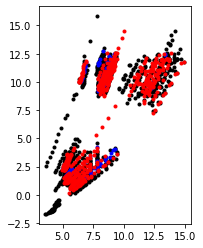

Size of viscous training subsets:

(1304, 5)
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(1153, 5)
X valid set shape, unscaled
(306, 5)
X test set shape, unscaled
(522, 5)

Entropy training shape, unscaled
(337, 4)
Entropy validation shape, unscaled
(62, 4)
Entropy testing shape, unscaled
(297, 4)


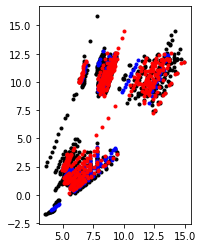

Size of viscous training subsets:

(1153, 5)
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(1005, 5)
X valid set shape, unscaled
(454, 5)
X test set shape, unscaled
(522, 5)

Entropy training shape, unscaled
(285, 4)
Entropy validation shape, unscaled
(114, 4)
Entropy testing shape, unscaled
(297, 4)


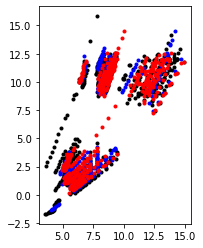

Size of viscous training subsets:

(1005, 5)
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(878, 5)
X valid set shape, unscaled
(581, 5)
X test set shape, unscaled
(522, 5)

Entropy training shape, unscaled
(237, 4)
Entropy validation shape, unscaled
(162, 4)
Entropy testing shape, unscaled
(297, 4)


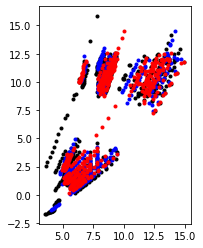

Size of viscous training subsets:

(878, 5)
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(700, 5)
X valid set shape, unscaled
(759, 5)
X test set shape, unscaled
(522, 5)

Entropy training shape, unscaled
(181, 4)
Entropy validation shape, unscaled
(218, 4)
Entropy testing shape, unscaled
(297, 4)


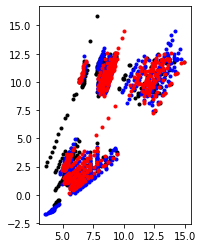

Size of viscous training subsets:

(700, 5)
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(569, 5)
X valid set shape, unscaled
(890, 5)
X test set shape, unscaled
(522, 5)

Entropy training shape, unscaled
(181, 4)
Entropy validation shape, unscaled
(218, 4)
Entropy testing shape, unscaled
(297, 4)


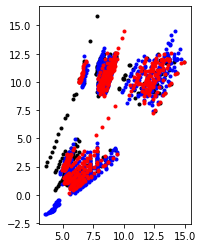

Size of viscous training subsets:

(569, 5)
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(423, 5)
X valid set shape, unscaled
(1036, 5)
X test set shape, unscaled
(522, 5)

Entropy training shape, unscaled
(170, 4)
Entropy validation shape, unscaled
(229, 4)
Entropy testing shape, unscaled
(297, 4)


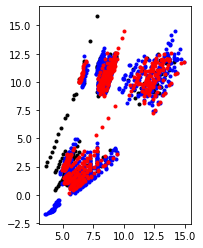

Size of viscous training subsets:

(423, 5)
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(256, 5)
X valid set shape, unscaled
(1203, 5)
X test set shape, unscaled
(522, 5)

Entropy training shape, unscaled
(120, 4)
Entropy validation shape, unscaled
(279, 4)
Entropy testing shape, unscaled
(297, 4)


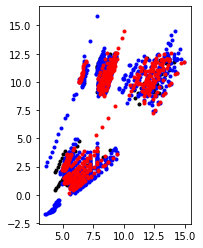

Size of viscous training subsets:

(256, 5)


In [3]:
# KNAS, comment to deactivate
dataset = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="VISCO")
print(dataset.columns)

fractions_valid = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80]
prefix= ["_0p10val","_0p20val","_0p30val","_0p40val","_0p50val","_0p60val","_0p70val","_0p80val"]
fraction_test = 0.20

for indice,value in enumerate(fractions_valid):
    pretreatment(dataset,value,fraction_test,"./data/DataSet"+prefix[indice]+".hdf5", rand_state=81)

# Density preparation

In [4]:
dataset = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="DENSITY")
dataset.head()

def prepare_density(dataset,output_file):
    
    # Import data
    X_d = dataset.loc[:, ["sio2","al2o3","na2o","k2o"]]/100.0
    y_d = dataset.loc[:, ["d"]]
    
    # train-test split
    X_tv, X_test, y_tv, y_test = model_selection.train_test_split(X_d, y_d, test_size=0.30, random_state=42)
    X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_tv, y_tv, test_size=0.20, random_state=42)

    # writing the data in HDF5 file for later call
    with h5py.File(output_file, 'w') as f:
        f.create_dataset('X_density_train', data=X_train)
        f.create_dataset('X_density_valid', data=X_valid)
        f.create_dataset('X_density_test',  data=X_test)

        f.create_dataset('y_density_train', data=y_train)
        f.create_dataset('y_density_valid', data=y_valid)
        f.create_dataset('y_density_test',  data=y_test)
        
    print("Done.")
        
prepare_density(dataset,"./data/NKAS_density.hdf5")

Done.


# Refractive Index preparation

In [5]:
dataset = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="OPTICAL")
dataset.head()

def prepare_ri(dataset,output_file):
    
    # Import data
    X_d = dataset.loc[:, ["sio2","al2o3","na2o","k2o"]]/100.0
    lbd_d = dataset.loc[:, ["lbd"]]*1e-3
    y_d = dataset.loc[:, ["ri"]]*1.0

    # train-test split
    X_tv, X_test, lbd_tv, lbd_test, y_tv, y_test = model_selection.train_test_split(X_d, lbd_d, y_d, test_size=0.30, random_state=42)
    X_train, X_valid, lbd_train, lbd_valid, y_train, y_valid = model_selection.train_test_split(X_tv, lbd_tv, y_tv, test_size=0.20, random_state=42)

    # writing the data in HDF5 file for later call
    with h5py.File(output_file, 'w') as f:
        f.create_dataset('X_ri_train', data=X_train)
        f.create_dataset('X_ri_valid', data=X_valid)
        f.create_dataset('X_ri_test',  data=X_test)

        f.create_dataset('lbd_ri_train', data=lbd_train)
        f.create_dataset('lbd_ri_valid', data=lbd_valid)
        f.create_dataset('lbd_ri_test',  data=lbd_test)

        f.create_dataset('y_ri_train', data=y_train)
        f.create_dataset('y_ri_valid', data=y_valid)
        f.create_dataset('y_ri_test',  data=y_test)

    print("Done.")
        
prepare_ri(dataset,"./data/NKAS_optical.hdf5")

Done.


# LIQUIDUS preparation

In [6]:
dataset = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="LIQUIDUS")
dataset.head()

def prepare_liquidus(dataset,output_file):
    
    # Import data
    X_Tl = dataset.loc[:, ["sio2","al2o3","na2o","k2o"]]/100
    Tl = dataset.loc[:, ["T_l_C"]]+273
    
    # train-test split
    X_tv, X_test, Tl_tv, Tl_test = model_selection.train_test_split(X_Tl, Tl, test_size=0.30, random_state=42)
    X_train, X_valid, Tl_train, Tl_valid = model_selection.train_test_split(X_tv, Tl_tv, test_size=0.20, random_state=42)

    # writing the data in HDF5 file for later call
    with h5py.File(output_file, 'w') as f:
        f.create_dataset('X_tl_train', data=X_train)
        f.create_dataset('X_tl_valid', data=X_valid)
        f.create_dataset('X_tl_test',  data=X_test)

        f.create_dataset('Tl_train', data=Tl_train)
        f.create_dataset('Tl_valid', data=Tl_valid)
        f.create_dataset('Tl_test',  data=Tl_test)

    print("Done.")
        
prepare_liquidus(dataset,"./data/NKAS_liquidus.hdf5")



Done.
